# FISH - Pipeline - A Python notebook to simulate FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Libraries

In [1]:
# Importing libraries
import sys
import pathlib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle
import os; from os import listdir; from os.path import isfile, join
import re

warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')

In [3]:
current_dir

PosixPath('/home/luisub/Desktop/FISH_Processing/simulation')

In [4]:
# Path to data
cell_library_folder_path = current_dir.joinpath('cell_library')
background_library_path = cell_library_folder_path.joinpath('background_pixels_library.npy')
dataframe_library_path = cell_library_folder_path.joinpath('dataframe_library.csv')


In [5]:
def read_files(directory):
    list_files_names_complete = sorted([f for f in listdir(directory) if isfile(join(directory, f)) and ('cell_') in f], key=str.lower)  # reading all tif files in the folder
    list_files_names_complete.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
    path_files_complete = [ str(directory.joinpath(f).resolve()) for f in list_files_names_complete ] # creating the complete path for each file
    list_library_cells =  [ np.load(f) for f in path_files_complete ]
    return list_library_cells

In [6]:
# extracting library data
background_pixels_library = np.load(background_library_path)    # 
dataframe_cell_library = pd.read_csv(dataframe_library_path)  # Returns a dataframe with the following columns [cell_id, size, number_of_spots,ts_size] and each row represents a cell.
list_library_cells = read_files(cell_library_folder_path)      # Returns a list of cells where each cell has the shape [Z,Y,X,C]


In [7]:
dataframe_cell_library.head()

,cell_id,centroid_y,centroid_x,y_size,x_size,nucleus_area,number_of_spots,ts_size
0,0,54,49,111,96,7733,476,20
1,1,35,47,76,95,5166,302,49
2,2,45,38,95,75,5471,289,18
3,3,35,46,74,93,5454,293,74
4,4,41,49,83,100,5888,316,48


___

# Function to simulate cell positions

In [8]:
def generate_simulated_positions (image_size_Z_Y_X,number_of_cells_in_simulation,list_library_cells,dataframe_cell_library,generate_cells_close_to_each_other=True):
    initial_dictionary_for_df = {
        'start_y_position': [],
        'start_x_position': [],
        'centroid_y': [],
        'centroid_x': [],
        'z_size': [],
        'y_size': [],
        'x_size': [],
        'nucleus_area': [],
        'number_of_spots': [],
        'ts_size': [],
        'library_id': [],
    }
    # this statement generate a large number of cells if generate_cells_close_to_each_other is true.
    if generate_cells_close_to_each_other == True:
        large_number_initial_simulation = number_of_cells_in_simulation*3
    else:
        large_number_initial_simulation = number_of_cells_in_simulation
    # Create the DataFrame
    number_cells_in_library = len(list_library_cells)
    max_cell_size = np.max( [np.max(cell.shape[1:3]) for _, cell in enumerate(list_library_cells)] )
    
    simulation_dataframe = pd.DataFrame(initial_dictionary_for_df)
    #max_cell_size 
    MAX_NUM_ITERATIONS = 20000
    printed_cells=0
    min_position_image_edge = max_cell_size
    max_y_position = image_size_Z_Y_X[1]-min_position_image_edge
    max_x_position = image_size_Z_Y_X[2]-min_position_image_edge
    counter=0
    # random indexes for selecting a cell from library
    number_cells_in_library = len(list_library_cells)
    rnd_index_cells = np.random.randint(0, number_cells_in_library,size=MAX_NUM_ITERATIONS).astype(int)
    # This creates a random positions with a len MAX_NUM_ITERATIONS
    y_positions = np.random.randint(min_position_image_edge, max_y_position-max_cell_size, size=MAX_NUM_ITERATIONS).astype(int)
    x_positions = np.random.randint(min_position_image_edge, max_x_position-max_cell_size, size=MAX_NUM_ITERATIONS).astype(int)
    z_positions = np.zeros(MAX_NUM_ITERATIONS,dtype=int)
    cell_size_Z_Y_X = np.zeros((number_cells_in_library,3))
    for i in range (number_cells_in_library):
        cell_size_Z_Y_X[i,:] = list_library_cells[i][:,:,:,0].shape
    # Main while loop that iterates until number_of_cell_in_image is reached or counter>MAX_NUM_ITERATIONS
    list_cells_position = []
    while (counter< MAX_NUM_ITERATIONS-1) and (printed_cells<=large_number_initial_simulation-1):
        add_cell = False
        tested_positions=[]
        if printed_cells >0:
            # Test cell positions
            cell_Z_Y_X_positions = [z_positions[counter], y_positions[counter], x_positions[counter]]
            tested_positions = list_cells_position.copy()
            tested_positions.append(cell_Z_Y_X_positions) 
            array_tested_positions = np.asarray( tested_positions)
            # Calculating a distance matrix. 
            distance_matrix = np.zeros( (array_tested_positions.shape[0], array_tested_positions.shape[0])) 
            for i in range(len(array_tested_positions)):
                for j in range(len(array_tested_positions)):
                    if j<i:
                        distance_matrix[i,j] = np.linalg.norm( ( array_tested_positions[i,:]-array_tested_positions[j,:] )  )
            # Masking the distance matrix. Ones indicate the distance is less or equal than threshold_distance
            mask_distance_matrix = (distance_matrix <= max_cell_size) 
            # Negation (NOT) of the distance_matrix .
            negation_subsection_mask_distance_matrix = ~mask_distance_matrix
            lower_diagonal_mask_distance_matrix = np.tril(negation_subsection_mask_distance_matrix, k=-1)
            add_cell = np.all(lower_diagonal_mask_distance_matrix[-1,:-1])
            del array_tested_positions
        else:
            cell_Z_Y_X_positions = [z_positions[counter], y_positions[counter], x_positions[counter]]
            add_cell = True
        if add_cell == True: 
            library_cell_index = rnd_index_cells[counter]
            list_cells_position.append(cell_Z_Y_X_positions)
            centroid_y = y_positions[counter] + cell_size_Z_Y_X[library_cell_index,1]//2
            centroid_x = x_positions[counter] + cell_size_Z_Y_X[library_cell_index,2]//2
            # extracting information about a given cell
            nucleus_area = dataframe_cell_library.loc[   (dataframe_cell_library['cell_id']==library_cell_index) ].nucleus_area.values[0]   
            number_of_spots = dataframe_cell_library.loc[   (dataframe_cell_library['cell_id']==library_cell_index) ].number_of_spots.values[0]   
            ts_size = dataframe_cell_library.loc[   (dataframe_cell_library['cell_id']==library_cell_index) ].ts_size.values[0]   
            cell_data = pd.Series([ y_positions[counter], x_positions[counter], centroid_y, centroid_x ,cell_size_Z_Y_X[library_cell_index,0], cell_size_Z_Y_X[library_cell_index,1], cell_size_Z_Y_X[library_cell_index,2], nucleus_area, number_of_spots, ts_size,library_cell_index ], index=simulation_dataframe.columns)
            simulation_dataframe = simulation_dataframe.append(cell_data, ignore_index=True)
            printed_cells+=1
        counter+=1
    new_dtypes = { 'start_y_position':int,'start_x_position':int,'centroid_y':int,'centroid_x':int,'z_size':int,'y_size':int,'x_size':int,'nucleus_area':int,'number_of_spots':int,'ts_size':int,'library_id':int}
    simulation_dataframe = simulation_dataframe.astype(new_dtypes)
    
    if generate_cells_close_to_each_other == True:
        # Calculating the distance matrix of selected cells
        tested_positions = simulation_dataframe[['start_y_position', 'start_x_position']]
        tested_positions.values.shape
        array_tested_positions = np.asarray( tested_positions)
        # Calculating a distance matrix. 
        distance_matrix = np.zeros( (array_tested_positions.shape[0], array_tested_positions.shape[0])) 
        for i in range(len(array_tested_positions)):
            for j in range(len(array_tested_positions)):
                distance_matrix[i,j] = np.linalg.norm( ( array_tested_positions[i,:]-array_tested_positions[j,:] )  )
        # Calculating the distance of the closest N cells around a given cell
        sum_rows = []
        number_neighbor_cell = 8
        for i in range(distance_matrix.shape[0]):
            row_values = distance_matrix[i]
            n_min_values_indices = np.argsort(row_values)[:number_neighbor_cell]
            sum_rows.append( np.sum(row_values[n_min_values_indices]))
        sum_rows = np.asarray(sum_rows)
        # Selecting only number_of_cells_in_simulation 
        selected_indices = np.argsort(sum_rows)[:number_of_cells_in_simulation]
        simulation_dataframe_new = simulation_dataframe.iloc[selected_indices].copy()
        simulation_dataframe_new = simulation_dataframe_new.reset_index(drop=True)
        #simulation_dataframe_new['number'] =simulation_dataframe_new.index
        simulation_dataframe_new
        simulation_dataframe = simulation_dataframe_new
        simulation_dataframe
    # Creating a new df selecting only the cells 
    return simulation_dataframe

In [9]:
complete_size = 4000

In [10]:
full_image_size_Z_Y_X = [27,complete_size,complete_size]
number_of_cells_in_simulation = 50
simulation_dataframe = generate_simulated_positions (full_image_size_Z_Y_X,number_of_cells_in_simulation,list_library_cells,dataframe_cell_library)
simulation_dataframe.tail()                                            

,start_y_position,start_x_position,centroid_y,centroid_x,z_size,y_size,x_size,nucleus_area,number_of_spots,ts_size,library_id
45,612,1570,648,1624,27,72,108,6129,196,0,24
46,2565,546,2612,598,27,95,105,7083,279,30,57
47,2260,503,2311,537,27,103,69,5324,216,27,80
48,3166,1093,3219,1137,27,107,89,7632,479,87,86
49,3432,1231,3468,1285,27,72,108,6129,196,0,24


# Generate simulation on demand

In [22]:
def make_simulated_image(z_position, y_position, x_position, x_size, y_size, full_image_size_Z_Y_X, simulation_dataframe, list_library_cells, background_pixels_library = None):
    number_color_channels = list_library_cells[0].shape[3]
    # Re-centering z_position index
    length_z_indices = full_image_size_Z_Y_X[0]
    z_array = np.arange(0,length_z_indices,1)
    z_position_center_as_zero = full_image_size_Z_Y_X[0]//2
    #z_position = z_position_center_as_zero + z_position
    z_array = [int(i - z_position_center_as_zero) if i < z_position_center_as_zero else int(i - z_position_center_as_zero) for i in range(length_z_indices)] 
    list_mean_background_pixels_library=[]
    list_std_background_pixels_library=[]
    if not background_pixels_library is None: 
        list_mean_background_pixels_library = [np.mean(background_pixels_library[i,:]) for i in range(number_color_channels)  ]
        list_std_background_pixels_library = [np.std(background_pixels_library[i,:]) for i in range(number_color_channels)  ]
    y_range = [y_position, y_position+ y_size]
    x_range = [x_position, x_position+x_size]
    #full_image_z_range = (0,full_image_size_Z_Y_X[0])
    # Detecting cells inside the selected region
    #z_pixels =  1 #z_range[1]-z_range[0]
    def min_edge_value_full_image (tested_value,edge_values,original_edge):
        if tested_value<edge_values:
            new_range = 0
        else:
            new_range = tested_value
        moved_pixels =abs(original_edge-new_range)
        return new_range,moved_pixels
    def max_edge_value_full_image (tested_value,edge_values,original_edge):
        if tested_value>edge_values:
            new_range = edge_values
        else:
            new_range = tested_value
        moved_pixels =abs(new_range-original_edge)
        return new_range,moved_pixels
    # extending the image range to consider cell on the image border
    additional_range = 200
    extended_y_min_range,moved_px_y_min = min_edge_value_full_image(y_range[0]-additional_range,0,y_range[0])
    extended_x_min_range,moved_px_x_min = min_edge_value_full_image(x_range[0]-additional_range,0,x_range[0])
    extended_y_max_range,moved_px_y_max = max_edge_value_full_image(y_range[1]+additional_range,full_image_size_Z_Y_X[1],y_range[1])
    extended_x_max_range,moved_px_x_max = max_edge_value_full_image(x_range[1]+additional_range,full_image_size_Z_Y_X[2],x_range[1])
    extended_y_pixels = extended_y_max_range - extended_y_min_range
    extended_x_pixels = extended_x_max_range - extended_x_min_range
    # Function to calculate ranges
    def return_ranges(selected_row, initial_x_range=None, initial_y_range=None):
        tested_x_size = selected_row.x_size
        tested_y_size = selected_row.y_size
        is_even_x = tested_x_size%2== 0
        is_even_y = tested_y_size%2== 0
        if not (initial_x_range is None):
            tested_x_position = selected_row.start_x_position - initial_x_range
        else:
            tested_x_position = selected_row.start_x_position
        if not (initial_y_range is None): 
            tested_y_position = selected_row.start_y_position - initial_y_range
        else:
            tested_y_position = selected_row.start_y_position 
        min_y_value = tested_y_position - tested_y_size//2
        max_y_value = tested_y_position + tested_y_size//2 + int(is_even_x)
        min_x_value = tested_x_position - tested_x_size//2
        max_x_value = tested_x_position + tested_x_size//2 + int(is_even_y)
        return min_y_value,max_y_value,min_x_value,max_x_value
    # Test one by one if a cell is located inside the extended area
    list_is_inside_range =[]
    for _, selected_row in simulation_dataframe.iterrows():
        min_y_value,max_y_value,min_x_value,max_x_value = return_ranges(selected_row,initial_x_range=None,initial_y_range=None)
        is_inside_range = (min_x_value >= extended_x_min_range) & (max_x_value <= extended_x_max_range) & (min_y_value >= extended_y_min_range) & (max_y_value <= extended_y_max_range)
        list_is_inside_range.append(is_inside_range)
    condition = np.array(list_is_inside_range)
    dataframe_cells_in_image = simulation_dataframe[condition]
    # take the image position and the cell location
    number_cells_in_library = len(list_library_cells)
    volume_simulated_image = np.zeros ((extended_y_pixels,extended_x_pixels,number_color_channels ),dtype=int)
    # Repetitive calculation performed over library of cells. Including cell shapes, cell_indexes, simulated volumes
    list_volume_tested_cell=[]    
    #print(z_position, z_array)
    for i in range (number_cells_in_library):
        # creating the image if z_position is inside z_array
        if np.isin(z_position, z_array):
            list_volume_tested_cell.append(list_library_cells[i][z_position,:,:,:].astype(np.uint16))
        else:
            # iterating for each color channel 
            temp_image = np.zeros_like(list_library_cells[i][0,:,:,:],dtype=np.uint16)
            for ch in range(number_color_channels):
                temp_image[:,:,ch] = np.max(list_library_cells[i][:,:,:,ch],axis=0)
            list_volume_tested_cell.append(temp_image)
            del temp_image
    # Lambda function to calculate edges in simulation
    min_edge_simulation = lambda tested_value:  0 if tested_value<0 else tested_value
    # main loop that creates the simulated image
    for _, selected_row in dataframe_cells_in_image.iterrows():
        library_id_selected = selected_row.library_id
        volume_selected_cell = list_volume_tested_cell[library_id_selected]
        min_y_value,max_y_value,min_x_value,max_x_value = return_ranges(selected_row,initial_x_range=extended_x_min_range,initial_y_range= extended_y_min_range)
        # Positions in final simulation
        y_min_in_simulation = min_edge_simulation(min_y_value)
        x_min_in_simulation = min_edge_simulation(min_x_value) 
        # Subsection of the volume to add to the final image
        sub_volume_selected_cell = volume_selected_cell.copy()
        sim_y_max = y_min_in_simulation + sub_volume_selected_cell.shape[0]
        sim_x_max = x_min_in_simulation + sub_volume_selected_cell.shape[1]
        # adding the cell to the image
        volume_simulated_image[y_min_in_simulation:sim_y_max,x_min_in_simulation:sim_x_max, :] =  sub_volume_selected_cell 
        del sub_volume_selected_cell
    # Loop that creates the final dataframe only if the nucleus centroid is inside the desired area.
    list_is_inside_range =[]
    for _, selected_row in dataframe_cells_in_image.iterrows():
        centroid_y = selected_row.centroid_y
        centroid_x = selected_row.centroid_x
        is_inside_range = (centroid_x >= x_range[0]) & (centroid_x <= x_range[1]) & (centroid_y >= y_range[0]) & (centroid_y <= y_range[1])
        list_is_inside_range.append(is_inside_range)
    # Test one by one if a cell is located inside the 
    condition_inside_final_area = np.array(list_is_inside_range)
    dataframe_cells_in_image = dataframe_cells_in_image[condition_inside_final_area]
    dataframe_cells_in_image.reset_index(drop=True,inplace=True)
    if not background_pixels_library is None: 
        # adding background noise
        simulated_image = np.zeros_like(volume_simulated_image)
        for i in range (number_color_channels):
            temp_simulated_image = volume_simulated_image[:,:,i].copy()
            zero_indices = np.where(temp_simulated_image == 0)
            random_elements = np.random.choice(background_pixels_library[i,:], size=len(zero_indices[0]))
            # Replace zero elements with random elements
            temp_simulated_image[zero_indices] = random_elements
            simulated_image[:,:,i] = temp_simulated_image
    else:
        simulated_image =volume_simulated_image
    # add a filter to the image if z is out of bounds
    if not np.isin(z_position, z_array):
        z_distance_from_edge = np.abs(z_position)-np.max(z_array)
        scaling_factor = 1*z_distance_from_edge
        sigma = 10  # The standard deviation of the Gaussian distribution
        for ch in range(number_color_channels):
            simulated_image[:,:,ch] =  gaussian_filter(simulated_image[:,:,ch], sigma*scaling_factor)
            if not background_pixels_library is None: 
                temp_simulated_image=simulated_image[:,:,ch].copy()
                indices_to_replace = np.where(temp_simulated_image < list_mean_background_pixels_library[ch])
                random_elements = np.random.choice(background_pixels_library[ch,:], size=len(indices_to_replace[0]))
            #    # Replace zero elements with random elements
                temp_simulated_image[indices_to_replace] = random_elements
                simulated_image[:,:,ch] = temp_simulated_image
            #    simulated_image[:,:,ch] =  np.max(simulated_image[:,:,ch],list_mean_background_pixels_library[ch])
    # Reshaping the final image
    simulated_image =simulated_image[moved_px_y_min:-moved_px_y_max-1,moved_px_x_min:-moved_px_x_max-1,:].copy()
    return simulated_image,dataframe_cells_in_image

293 2068
170 1395


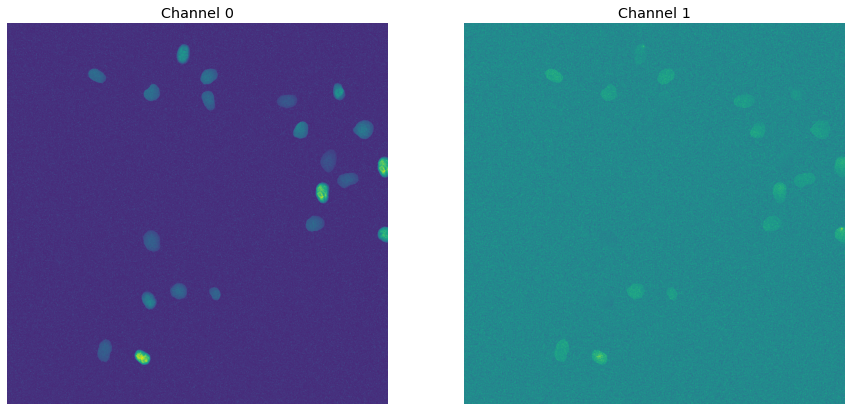

In [23]:
# Region to display
z_position = 0 #[-13:13]
y_position =  200
x_position = 100
x_size = 2000
y_size = 2000
simulated_image,dataframe_cells_in_image = make_simulated_image(z_position,y_position,x_position,x_size, y_size, full_image_size_Z_Y_X,simulation_dataframe,list_library_cells,background_pixels_library)

# Plotting
number_color_channels = simulated_image.shape[2]
fig, ax = plt.subplots(1,number_color_channels, figsize=(15, 7))
# Plotting the heatmap of a section in the image
for i in range (number_color_channels):
    simulated_image_removed_extreme_values = fa.RemoveExtrema(simulated_image[:,:,i],min_percentile=0, max_percentile=99.9).remove_outliers()  #np.max(simulated_image[:,:,:,i],axis = 0)
    ax[i].imshow(simulated_image_removed_extreme_values);ax[i].set(title='Channel '+ str(i)); ax[i].axis('off');ax[i].grid(False)
    print(np.min(simulated_image_removed_extreme_values),np.max(simulated_image_removed_extreme_values))
plt.show()



In [13]:
dataframe_cells_in_image

,start_y_position,start_x_position,centroid_y,centroid_x,z_size,y_size,x_size,nucleus_area,number_of_spots,ts_size,library_id
0,923,1787,984,1830,27,123,87,7723,220,0,88
1,1026,1888,1066,1943,27,80,111,6505,134,35,42
2,1091,1756,1146,1792,27,110,72,6291,241,49,17
3,759,1969,808,2023,27,98,109,7748,178,40,59
4,481,1160,522,1205,27,82,90,5608,130,0,55
5,608,1155,659,1190,27,102,71,5349,52,0,39
6,761,1641,806,1680,27,90,79,5439,168,70,26
7,564,859,608,901,27,89,85,5453,206,14,29
8,1252,1716,1293,1765,27,83,99,6333,124,0,37
9,478,573,516,620,27,76,94,4940,251,0,35


100 2000
100 2000


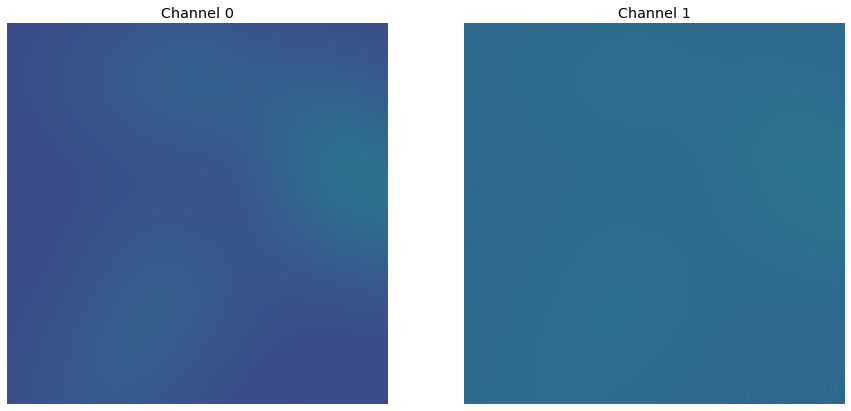

In [25]:
z_position = -40
y_position =  200
x_position = 100
x_size = 2000
y_size = 2000
simulated_image,dataframe_cells_in_image = make_simulated_image(z_position,y_position,x_position,x_size, y_size, full_image_size_Z_Y_X,simulation_dataframe,list_library_cells,background_pixels_library)

# Plotting
number_color_channels = simulated_image.shape[2]
fig, ax = plt.subplots(1,number_color_channels, figsize=(15, 7))
# Plotting the heatmap of a section in the image
for i in range (number_color_channels):
    simulated_image_removed_extreme_values = fa.RemoveExtrema(simulated_image[:,:,i],min_percentile=0, max_percentile=99.9).remove_outliers()  #np.max(simulated_image[:,:,:,i],axis = 0)
    simulated_image_removed_extreme_values[0,0]=100
    simulated_image_removed_extreme_values[0,1]=2000
    ax[i].imshow(simulated_image_removed_extreme_values);ax[i].set(title='Channel '+ str(i)); ax[i].axis('off');ax[i].grid(False)
    print(np.min(simulated_image_removed_extreme_values),np.max(simulated_image_removed_extreme_values))

plt.show()
